In [2]:
import pandas as pd
import numpy as np

C:\Users\raine\AppData\Local\Temp\ipykernel_23868\2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# EXTRACTED MENU ITEMS 

In [ ]:
import os
import base64
import re
from anthropic import Anthropic
from collections import defaultdict
import logging # Import logging
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def encode_image(image_path):
    """
    Encode an image file to base64.

    :param image_path: Path to the image file
    :return: Base64 encoded string of the image
    """
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        logging.error(f"Image file not found: {image_path}")
        return None
    except Exception as e:
        logging.error(f"Error encoding image {image_path}: {e}")
        return None

def extract_text_from_image(api_key, image_paths, prompt_text):
    """
    Use Claude to extract text from multiple images.

    :param api_key: Your Anthropic API key
    :param image_paths: List of paths to image files
    :param prompt_text: Text prompt for Claude
    :return: Extracted text from the images
    """
    # Initialize the Anthropic client
    client = Anthropic(api_key=api_key)

    try:
        # Create content array
        content = []

        # Add each image to the content array
        image_added = False
        for image_path in image_paths:
            # Determine media type based on file extension
            media_type = "image/jpeg"  # Default
            if image_path.lower().endswith(".png"):
                media_type = "image/png"
            elif image_path.lower().endswith(".gif"):
                media_type = "image/gif"
            elif image_path.lower().endswith(".webp"):
                 media_type = "image/webp" # Add webp support


            # Encode the image
            logging.info(f"Encoding image: {os.path.basename(image_path)}")
            base64_image = encode_image(image_path)

            if base64_image:
                # Add image to content array
                content.append({
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": media_type,
                        "data": base64_image
                    }
                })
                image_added = True
            else:
                logging.warning(f"Skipping image due to encoding error: {os.path.basename(image_path)}")

        if not image_added:
            logging.error("No images could be successfully encoded and added.")
            return None

        # Add text prompt at the end
        content.append({
            "type": "text",
            "text": prompt_text
        })

        # Send request to Claude
        logging.info("Sending request to Claude API...")
        response = client.messages.create(
            model="claude-3-haiku-20240307", # Using Haiku for speed/cost balance
            # model="claude-3-opus-20240229", # Opus might give better results but is slower/more expensive
            max_tokens=4000, # Increased max_tokens slightly
            messages=[
                {
                    "role": "user",
                    "content": content
                }
            ]
        )

        # Return the extracted text
        extracted_text = response.content[0].text
        logging.info(f"Received response from Claude. Content length: {len(extracted_text)} characters.")
        # Log first few lines of response for debugging
        # logging.debug("Claude Response Head:\n" + "\n".join(extracted_text.split('\n')[:5]))
        return extracted_text

    except Exception as e:
        logging.error(f"An error occurred during Claude API call: {e}", exc_info=True) # Log traceback
        return None

def parse_menu_items(extracted_text):
    """
    Parse menu items, prices, and categories from extracted text.

    :param extracted_text: Text extracted from the image by Claude
    :return: Dictionary of menu items {name: {'price': float, 'category': str}}, plus confidence scores {name: float}
    """
    menu_items = {}
    confidence_scores = {}

    # Basic check if extraction returned anything
    if not extracted_text or not extracted_text.strip():
        logging.warning("Received empty or null text from extraction.")
        return {}, {}

    # Split the text into lines
    lines = extracted_text.strip().split('\n')
    total_non_empty_lines = sum(1 for line in lines if line.strip())
    successful_extractions = 0
    unclear_items = 0
    default_category_items = 0

    logging.info(f"Parsing {total_non_empty_lines} non-empty lines from Claude output.")

    # --- Refined Regex Patterns ---
    # Price pattern: Handles various currency symbols (optional), commas, and decimals
    # Makes currency symbol and spacing optional. Allows integer prices.
    price_pattern = r'(?:[$€£¥]\s*|\b)(\d+(?:,\d{3})*(?:\.\d{1,2})?)\b'
    # Regex to find item name, price, and category (assumes format: NAME PRICE CATEGORY)
    # It tries to be flexible with spacing and potential currency symbols.
    # Group 1: Item Name (non-greedy)
    # Group 2: Price (using price_pattern logic)
    # Group 3: Category (rest of the line)
    # This regex is complex and might need tuning based on Claude's actual output format.
    # Let's try a simpler approach first: find price, then split.

    for line_num, line in enumerate(lines):
        line = line.strip()
        # Skip empty lines or potential headers/footers from Claude
        if not line or line.startswith("Here are the items") or line.startswith("---"):
            continue

        line_confidence = 1.0  # Start with full confidence

        # Check for uncertainty indicators in the text (global line check)
        uncertainty_phrases = ["unclear", "can't make out", "illegible", "not visible", "hard to read", "possibly", "maybe", "appears to be"]
        is_unclear = False
        for phrase in uncertainty_phrases:
            if phrase in line.lower():
                line_confidence *= 0.6  # Reduce confidence if uncertainty is indicated globally
                is_unclear = True
                # break # Found one, no need to check others for this line

        # 1. Find the price first (more reliable anchor)
        price_match = re.search(price_pattern, line)

        if price_match:
            # Extract the price and convert to float
            price_str = price_match.group(1).replace(',', '')
            try:
                price = float(price_str)
            except ValueError:
                logging.warning(f"Line {line_num+1}: Could not convert price '{price_str}' to float. Skipping line: '{line}'")
                continue

            # 2. Extract Item Name (everything before the price match)
            item_name = line[:price_match.start()].strip()
            # Clean up common trailing characters before price
            item_name = re.sub(r'[.…\-_*\s]+$', '', item_name).strip()

            # 3. Extract Category (everything after the price match)
            category_name = line[price_match.end():].strip()
            # Clean up common leading characters after price
            category_name = re.sub(r'^[.…\-_*\s]+', '', category_name).strip()

            # --- Data Cleaning and Validation ---
            # Handle empty item name (likely parsing error or header)
            if not item_name:
                 logging.warning(f"Line {line_num+1}: Extracted empty item name. Skipping line: '{line}'")
                 continue

            # Handle empty or default category
            if not category_name or category_name.lower() in ["unclear", "unknown", "n/a", "none", "-", "--"]:
                category_name = "Uncategorized" # Standardize default
                line_confidence *= 0.8 # Slightly reduce confidence if category was unclear/missing
                default_category_items += 1

            # Remove any "(unclear)" tags added by Claude from name/category
            item_name = item_name.replace("(unclear)", "").strip()
            category_name = category_name.replace("(unclear)", "").strip()

            # If the global 'unclear' flag was set, mark item count
            if is_unclear:
                unclear_items += 1


            # Check name/category quality (very short strings might be noise)
            if len(item_name) < 3:
                line_confidence *= 0.8
            if len(category_name) < 3 and category_name != "Uncategorized": # Allow short defaults
                 line_confidence *= 0.9 # Less penalty for short category

            # Check price reasonableness
            if price <= 0 or price > 1000: # Adjusted range slightly
                line_confidence *= 0.7

            # Store the item
            successful_extractions += 1
            item_key = item_name # Use name as the key

            # Handle duplicate item names (append index if price/category differ)
            if item_key in menu_items:
                 existing_item = menu_items[item_key]
                 # Only create variant if price OR category is different
                 if existing_item['price'] != price or existing_item['category'] != category_name:
                     count = 1
                     new_key = f"{item_name} ({count})"
                     while new_key in menu_items:
                         count += 1
                         new_key = f"{item_name} ({count})"
                     item_key = new_key
                     logging.info(f"Duplicate item name '{item_name}' found with different price/category. Storing as '{item_key}'.")
                 else:
                     # Exact duplicate, maybe increase confidence slightly? Or just skip. Let's skip.
                     logging.info(f"Exact duplicate item found: '{item_name}'. Skipping.")
                     successful_extractions -= 1 # Decrement success counter as we skipped it
                     continue # Skip to next line

            menu_items[item_key] = {'price': price, 'category': category_name}
            confidence_scores[item_key] = max(0.0, min(1.0, line_confidence)) # Clamp confidence 0-1

        else:
            # Line did not contain a recognizable price pattern
            logging.warning(f"Line {line_num+1}: No valid price pattern found. Skipping line: '{line}'")

    # Calculate overall extraction quality metrics
    extraction_rate = successful_extractions / total_non_empty_lines if total_non_empty_lines > 0 else 0
    avg_confidence = sum(confidence_scores.values()) / len(confidence_scores) if confidence_scores else 0

    # Log the extraction metrics
    logging.info(f"Parsing complete. Successfully extracted {successful_extractions} items.")
    logging.info(f"Extraction rate: {extraction_rate:.1%} of non-empty lines.")
    logging.info(f"Items marked unclear by Claude or parser: {unclear_items}")
    logging.info(f"Items assigned default 'Uncategorized' category: {default_category_items}")
    logging.info(f"Average confidence score for extracted items: {avg_confidence:.1%}")

    return menu_items, confidence_scores

def categorize_menu_items(menu_items, num_categories=3):
    """
    Categorize menu items based on their price into groups like A, B, C.

    :param menu_items: Dictionary {name: {'price': float, 'category': str}}
    :param num_categories: Number of price categories (A, B, C...)
    :return: Dictionary {price_category: [{'name': str, 'price': float, 'category': str}, ...]}
    """
    if not menu_items:
        logging.warning("No menu items provided for price categorization.")
        return {}

    # Prepare items list: [{'name': name, 'price': price, 'category': category}, ...]
    items_list = [{'name': name, **data} for name, data in menu_items.items()]

    # Sort items by price (descending)
    sorted_items_list = sorted(items_list, key=lambda x: x['price'], reverse=True)

    # Determine price ranges
    prices = [item['price'] for item in sorted_items_list]
    if not prices: # Should not happen if menu_items is not empty, but safety check
        return {}

    max_price = max(prices)
    min_price = min(prices)
    price_range = max_price - min_price

    logging.info(f"\nPrice range for categorization: ${min_price:.2f} to ${max_price:.2f} (Spread: ${price_range:.2f})")

    # Create categories based on price ranges
    # Result structure: {'A': [item_dict1, item_dict2], 'B': [...]}
    categories = defaultdict(list)

    # Handle edge cases: zero range or only one category requested
    if num_categories <= 1 or price_range == 0:
        logging.info("Assigning all items to Category A (single category requested or zero price range).")
        categories['A'].extend(sorted_items_list)
        return dict(categories) # Convert back to dict from defaultdict

    # --- Adaptive Categorization Logic (from original code) ---
    # Decide whether to use equal price range division or percentile-based division
    large_range_threshold = 3.0 # Use adaptive if range > 3x min price
    use_adaptive = price_range > min_price * large_range_threshold and min_price > 0

    if use_adaptive:
        logging.info(f"Large price range detected (range/min > {large_range_threshold:.1f}) - using adaptive (percentile-based) categorization.")

        num_items = len(sorted_items_list)
        category_boundaries = [] # List of lower bounds for categories B, C, D...

        # Calculate boundary prices based on item count percentiles
        for i in range(1, num_categories):
            idx = int((i * num_items) / num_categories)
            # Use the price of the item at the boundary index as the threshold
            # Ensure index is valid
            if 0 <= idx < num_items:
                 # The boundary is the price *below which* items fall into the next category
                 # So, category A is >= boundary[0], B is < boundary[0] and >= boundary[1], etc.
                 boundary_price = sorted_items_list[idx]['price']
                 # Add a small epsilon if needed to handle exact matches at boundaries consistently
                 # Let's adjust logic: boundary price IS the lower limit for the higher category
                 category_boundaries.append(boundary_price)
            else:
                 # Should not happen with valid indices, but handle gracefully
                 logging.warning(f"Could not determine boundary price for category {chr(65 + i)}")
                 # Use the previous boundary or min price as fallback
                 category_boundaries.append(category_boundaries[-1] if category_boundaries else min_price)

        # Ensure boundaries are unique and sorted descending
        category_boundaries = sorted(list(set(category_boundaries)), reverse=True)

        # Add the minimum price as the effective floor for the last category
        category_boundaries.append(min_price - 0.01) # Ensure min_price items are included

        boundary_strs = [f">${b:.2f}" for b in category_boundaries[:-1]] # Don't print the floor boundary
        logging.info(f"Adaptive category price boundaries (Min price for Cat A, B, C...): {boundary_strs}")

        # Assign items to categories based on these boundaries
        for item_dict in sorted_items_list:
            item_price = item_dict['price']
            assigned = False
            # Find the first boundary the price is >= to
            for i, boundary in enumerate(category_boundaries[:-1]): # Iterate through A, B, C... boundaries
                 if item_price >= boundary:
                     category_letter = chr(65 + i)
                     categories[category_letter].append(item_dict)
                     assigned = True
                     break
            # If not assigned (should only happen for min_price items falling below last explicit boundary)
            if not assigned:
                 # Assign to the last category
                 category_letter = chr(65 + num_categories - 1)
                 categories[category_letter].append(item_dict)

    else:
        # --- Standard Equal Price Range Division ---
        logging.info("Using standard categorization (equal price range division).")
        # Avoid division by zero if num_categories is 0 or less (handled earlier, but safety)
        if num_categories <= 0: num_categories = 1
        category_range_size = price_range / num_categories

        # Print calculated category ranges
        logging.info(f"Calculated category range size: ${category_range_size:.2f}")
        for i in range(num_categories):
             cat_letter = chr(65 + i)
             cat_max = max_price - (i * category_range_size)
             cat_min = max_price - ((i + 1) * category_range_size)
             # Ensure the last category includes the minimum price exactly
             if i == num_categories - 1: cat_min = min_price
             logging.info(f"  Target range for Category {cat_letter}: ~${cat_min:.2f} - ${cat_max:.2f}")


        for item_dict in sorted_items_list:
            item_price = item_dict['price']
            # Determine category index based on price position within the total range
            # Handle max_price edge case: should be in Category A (index 0)
            if item_price == max_price:
                category_index = 0
            # Avoid division by zero if category_range_size is 0 (handled earlier, but safety)
            elif category_range_size > 0:
                 # Calculate how many 'ranges' down from the max price this item is
                 category_index = int((max_price - item_price) / category_range_size)
                 # Clamp index to valid range [0, num_categories - 1]
                 category_index = max(0, min(num_categories - 1, category_index))
            else: # category_range_size is 0 (all prices same) -> should be handled by initial check
                 category_index = 0

            category_letter = chr(65 + category_index)
            categories[category_letter].append(item_dict)

    # Log the distribution of items across final categories
    logging.info("\n--- Final Item Distribution by Price Category ---")
    for category_letter, items in sorted(categories.items()):
        category_min_price = min(item['price'] for item in items) if items else 0
        category_max_price = max(item['price'] for item in items) if items else 0
        logging.info(f"Category {category_letter}: {len(items)} items. Actual price range: ${category_min_price:.2f} - ${category_max_price:.2f}")

    return dict(categories) # Convert back to regular dict


def process_menu_images(api_key, image_folder, num_price_categories=3):
    """
    Process all menu images in a folder, extract items (name, price, category),
    and categorize them by price tiers (A, B, C...).

    :param api_key: Your Anthropic API key
    :param image_folder: Path to folder containing menu images
    :param num_price_categories: Number of price categories (A, B, C...)
    :return: Price-categorized menu items dict, and overall confidence scores dict
    """
    # List all image files in the folder
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.webp'] # Added webp
    image_paths = []

    if not os.path.isdir(image_folder):
        logging.error(f"Image folder not found or is not a directory: {image_folder}")
        return {}, {}

    for file in os.listdir(image_folder):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_paths.append(os.path.join(image_folder, file))

    if not image_paths:
        logging.error(f"No supported image files ({', '.join(image_extensions)}) found in {image_folder}")
        return {}, {}

    logging.info(f"Found {len(image_paths)} images to process in folder: {image_folder}")

    # Store all items extracted across all images before final categorization
    # Using the structure: {name: {'price': float, 'category': str}}
    all_menu_items_combined = {}
    all_confidence_scores_combined = {}
    image_extraction_counts = []

    # --- Updated Prompt for Claude ---
    prompt_text = f"""
    Please extract all menu items from the provided image(s).

For each distinct menu item found, provide the following information on a single line:
1. The complete Item Name in English (if available).
2. The Thai name of the item (if available).
3. If only Thai OR only English name is available, just extract what is present and mark the other blank
4. The exact Price (including currency symbol like $ or ฿ if visible, otherwise just the number).
5. The item's Category (e.g., Appetizer, Main Course, Dessert, Beverage, Side Dish).

Format each item STRICTLY as:
English Item Name Thai Item Name $Price Category

Examples (menu item is available in both english and thai):
Classic Caesar Salad ซีซาร์สลัดคลาสสิค $12.99 Appetizer
Grilled Salmon Fillet ปลาแซลมอนย่าง $24.50 Main Course
New York Cheesecake นิวยอร์กชีสเค้ก $8.00 Dessert
Iced Tea ชาเย็น $3.50 Beverage
French Fries เฟรนช์ฟรายส์ $5.00 Side Dish

Examples (menu item is only available in english):
Pad Thai $12.99 Main Course
Classic Caesar Salad $12.99 Appetizer
Grilled Salmon Fillet $24.50 Main Course
New York Cheesecake $8.00 Dessert
Iced Tea $3.50 Beverage
French Fries $5.00 Side Dish

Examples (menu item is only available in thai):
ผัดไทย $12.99 Main Course
ซีซาร์สลัดคลาสสิค $12.99 Appetizer
ปลาแซลมอนย่าง $24.50 Main Course
นิวยอร์กชีสเค้ก $8.00 Dessert
ชาเย็น $3.50 Beverage
เฟรนช์ฟรายส์ $5.00 Side Dish

IMPORTANT INSTRUCTIONS:
- List EVERY visible menu item, and do not include the menu item details.
- If you cannot clearly determine any part (Price or Category), use the placeholder "(unclear)" for that specific part.
- If the category is totally unknown, use "Uncategorized".
- Ensure the price is extracted accurately.
- Do NOT add any introductory text, explanations, summaries, or formatting like bullet points or markdown.
- Only output the list of items in the specified format, one item per line.
- If an item seems to span multiple lines in the menu image, combine it into a single logical item name if possible.
- Pay attention to sections or headers in the menu image to help determine the category.
    """

    # Process images (can be done one-by-one or batched if API/model supports it well)
    # Let's stick to one-by-one for simplicity and robustness against single image failures.
    for idx, image_path in enumerate(image_paths):
        logging.info(f"\n--- Processing image {idx+1}/{len(image_paths)}: {os.path.basename(image_path)} ---")

        extracted_text = extract_text_from_image(api_key, [image_path], prompt_text)

        if extracted_text:
            logging.info(f"Text extraction successful for {os.path.basename(image_path)}. Parsing content...")

            # Parse menu items (name, price, category) from this image's text
            menu_items_single, confidence_scores_single = parse_menu_items(extracted_text)
            item_count_single = len(menu_items_single)
            logging.info(f"Parsed {item_count_single} items from {os.path.basename(image_path)}.")
            image_extraction_counts.append((os.path.basename(image_path), item_count_single))

            # Merge items from this image into the combined dictionary
            for item_name, item_data in menu_items_single.items():
                confidence = confidence_scores_single.get(item_name, 0.5) # Default confidence if missing

                # Check if item already exists in combined list
                if item_name in all_menu_items_combined:
                    existing_data = all_menu_items_combined[item_name]
                    # If price or category differs, create a variant
                    if existing_data['price'] != item_data['price'] or existing_data['category'] != item_data['category']:
                        variant_count = 1
                        variant_name = f"{item_name} (Img {idx+1})" # Add image source to variant name
                        while variant_name in all_menu_items_combined:
                             variant_count += 1
                             variant_name = f"{item_name} (Img {idx+1} Var {variant_count})"

                        logging.warning(f"Item '{item_name}' from {os.path.basename(image_path)} differs from previous entry. Storing as '{variant_name}'. "
                                        f"Old: P={existing_data['price']}, C='{existing_data['category']}'. New: P={item_data['price']}, C='{item_data['category']}'.")
                        all_menu_items_combined[variant_name] = item_data
                        all_confidence_scores_combined[variant_name] = confidence
                    else:
                         # Exact same item found again, potentially update confidence if higher?
                         # For now, let's keep the first encountered confidence.
                         logging.info(f"Item '{item_name}' is an exact duplicate from another image. Skipping.")
                else:
                    # New item, add it
                    all_menu_items_combined[item_name] = item_data
                    all_confidence_scores_combined[item_name] = confidence

            logging.info(f"Combined total unique items so far: {len(all_menu_items_combined)}")
        else:
            logging.error(f"Failed to extract text from {os.path.basename(image_path)}. Skipping this image.")
            image_extraction_counts.append((os.path.basename(image_path), 0)) # Record failure

    # --- Post-Processing and Categorization ---
    logging.info(f"\n===== Image Processing Summary =====")
    total_items_extracted = sum(count for _, count in image_extraction_counts)
    logging.info(f"Total items parsed across all images (before deduplication/variants): {total_items_extracted}")
    logging.info(f"Final unique items/variants stored: {len(all_menu_items_combined)}")

    # Print extraction performance by image
    logging.info("\nItems Parsed Per Image:")
    for image_name, item_count in image_extraction_counts:
        logging.info(f"  {image_name}: {item_count} items")

    # Calculate overall average confidence score
    if all_confidence_scores_combined:
        avg_confidence = sum(all_confidence_scores_combined.values()) / len(all_confidence_scores_combined)
        logging.info(f"Overall average extraction confidence: {avg_confidence:.1%}")
    else:
         logging.info("No confidence scores available.")


    if not all_menu_items_combined:
        logging.error("No menu items were successfully extracted from any images.")
        return {}, {}

    # --- Dynamic Adjustment of Price Categories ---
    # Adjust num_categories based on item count for better distribution
    min_items_per_category = 3 # Aim for at least 3 items per category if possible
    max_possible_categories = len(all_menu_items_combined) // min_items_per_category
    adjusted_categories = max(1, min(num_price_categories, max_possible_categories))

    if adjusted_categories != num_price_categories:
        logging.warning(f"Adjusting number of price categories from {num_price_categories} to {adjusted_categories} "
                      f"based on item count ({len(all_menu_items_combined)}) and target minimum items per category ({min_items_per_category}).")
        num_price_categories = adjusted_categories
    else:
         logging.info(f"Using requested number of price categories: {num_price_categories}")

    # Categorize the combined menu items by price tiers (A, B, C...)
    logging.info("\n--- Categorizing All Extracted Items by Price ---")
    final_price_categories = categorize_menu_items(all_menu_items_combined, num_price_categories)

    return final_price_categories, all_confidence_scores_combined

def main():
    # --- Configuration ---
    # IMPORTANT: Replace with your actual Anthropic API key
    # Consider using environment variables for API keys in production
    API_KEY = os.environ.get('ANTHROPIC_API_KEY') # Looks for env var first

    if not API_KEY:
        logging.error("CRITICAL: Anthropic API key not found. Set the ANTHROPIC_API_KEY environment variable or replace 'YOUR_API_KEY_HERE' in the script.")
        return

    # Path to your folder containing menu images
    IMAGE_FOLDER = './sample/ENG MENUS/Box Office Bar & Café at Prince Theatre Heritage Stay' # Make sure this folder exists and contains images

    # Target number of *price* categories (e.g., A, B, C, D for 4 categories)
    NUM_PRICE_CATEGORIES = 4

    # Output file name
    OUTPUT_FILENAME = "categorized_menu_items_claude.txt"
    # --- End Configuration ---


    logging.info("===== MENU ITEM EXTRACTION AND PRICE CATEGORIZATION =====")
    logging.info(f"Processing menu images from folder: {os.path.abspath(IMAGE_FOLDER)}")
    logging.info(f"Target number of price categories: {NUM_PRICE_CATEGORIES}")

    # Create image folder if it doesn't exist (useful for first run)
    if not os.path.exists(IMAGE_FOLDER):
        try:
            os.makedirs(IMAGE_FOLDER)
            logging.info(f"Created image folder: {IMAGE_FOLDER}")
            logging.warning("Image folder was created, but it's currently empty. Please add menu images to it.")
            return # Stop execution if folder was just created empty
        except OSError as e:
            logging.error(f"Failed to create image folder {IMAGE_FOLDER}: {e}")
            return


    # Process menu images
    price_categories, confidence_scores = process_menu_images(API_KEY, IMAGE_FOLDER, NUM_PRICE_CATEGORIES)

    if price_categories:
        # --- Output Results ---
        menu_rows = []
        for category_letter, items in sorted(price_categories.items()):
            if items:
                # Sort items within the category by price (desc) for writing
                items_sorted = sorted(items, key=lambda x: x['price'], reverse=True)

                for item_dict in items_sorted:
                    menu_rows.append({
                        'Category': item_dict['category'],
                        'Name': item_dict['name'],
                        'Price': item_dict['price']
                    })

        ocr_df = pd.DataFrame(menu_rows, columns=['Category', 'Name', 'Price'])
        return ocr_df
    else:
        logging.error("Processing finished, but no menu items were found or categorized.")

if __name__ == "__main__":
    ocr_df = main()

2025-05-09 00:18:54,075 - INFO - ===== MENU ITEM EXTRACTION AND PRICE CATEGORIZATION =====
2025-05-09 00:18:54,078 - INFO - Processing menu images from folder: c:\wamp64\www\hungryhub_automation\sample\ENG MENUS\Box Office Bar & Café at Prince Theatre Heritage Stay
2025-05-09 00:18:54,079 - INFO - Target number of price categories: 4
2025-05-09 00:18:54,083 - INFO - Found 8 images to process in folder: ./sample/ENG MENUS/Box Office Bar & Café at Prince Theatre Heritage Stay
2025-05-09 00:18:54,085 - INFO - 
--- Processing image 1/8: A4 Drinks_outline_pages-to-jpg-0001.jpg ---
2025-05-09 00:18:55,258 - INFO - Encoding image: A4 Drinks_outline_pages-to-jpg-0001.jpg
2025-05-09 00:18:55,271 - INFO - Sending request to Claude API...
2025-05-09 00:19:01,064 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-09 00:19:01,070 - INFO - Received response from Claude. Content length: 1307 characters.
2025-05-09 00:19:01,072 - INFO - Text extraction successf

In [10]:
import os
import base64
import re
from anthropic import Anthropic
from collections import defaultdict
import logging # Import logging
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def encode_image(image_path):
    """
    Encode an image file to base64.

    :param image_path: Path to the image file
    :return: Base64 encoded string of the image
    """
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        logging.error(f"Image file not found: {image_path}")
        return None
    except Exception as e:
        logging.error(f"Error encoding image {image_path}: {e}")
        return None

def extract_text_from_image(api_key, image_paths, prompt_text):
    """
    Use Claude to extract text from multiple images.

    :param api_key: Your Anthropic API key
    :param image_paths: List of paths to image files
    :param prompt_text: Text prompt for Claude
    :return: Extracted text from the images
    """
    # Initialize the Anthropic client
    client = Anthropic(api_key=api_key)

    try:
        # Create content array
        content = []

        # Add each image to the content array
        image_added = False
        for image_path in image_paths:
            # Determine media type based on file extension
            media_type = "image/jpeg"  # Default
            if image_path.lower().endswith(".png"):
                media_type = "image/png"
            elif image_path.lower().endswith(".gif"):
                media_type = "image/gif"
            elif image_path.lower().endswith(".webp"):
                 media_type = "image/webp" # Add webp support


            # Encode the image
            logging.info(f"Encoding image: {os.path.basename(image_path)}")
            base64_image = encode_image(image_path)

            if base64_image:
                # Add image to content array
                content.append({
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": media_type,
                        "data": base64_image
                    }
                })
                image_added = True
            else:
                logging.warning(f"Skipping image due to encoding error: {os.path.basename(image_path)}")

        if not image_added:
            logging.error("No images could be successfully encoded and added.")
            return None

        # Add text prompt at the end
        content.append({
            "type": "text",
            "text": prompt_text
        })

        # Send request to Claude
        logging.info("Sending request to Claude API...")
        response = client.messages.create(
            model="claude-3-haiku-20240307", # Using Haiku for speed/cost balance
            # model="claude-3-opus-20240229", # Opus might give better results but is slower/more expensive
            max_tokens=4000, # Increased max_tokens slightly
            messages=[
                {
                    "role": "user",
                    "content": content
                }
            ]
        )

        # Return the extracted text
        extracted_text = response.content[0].text
        logging.info(f"Received response from Claude. Content length: {len(extracted_text)} characters.")
        # Log first few lines of response for debugging
        # logging.debug("Claude Response Head:\n" + "\n".join(extracted_text.split('\n')[:5]))
        return extracted_text

    except Exception as e:
        logging.error(f"An error occurred during Claude API call: {e}", exc_info=True) # Log traceback
        return None

def parse_menu_items(extracted_text):
    """
    Parse menu items, prices, and categories from extracted text.

    :param extracted_text: Text extracted from the image by Claude
    :return: Dictionary of menu items {name: {'price': float, 'category': str}}, plus confidence scores {name: float}
    """
    menu_items = {}
    confidence_scores = {}

    # Basic check if extraction returned anything
    if not extracted_text or not extracted_text.strip():
        logging.warning("Received empty or null text from extraction.")
        return {}, {}

    # Split the text into lines
    lines = extracted_text.strip().split('\n')
    total_non_empty_lines = sum(1 for line in lines if line.strip())
    successful_extractions = 0
    unclear_items = 0
    default_category_items = 0

    logging.info(f"Parsing {total_non_empty_lines} non-empty lines from Claude output.")

    # --- Refined Regex Patterns ---
    # Price pattern: Handles various currency symbols (optional), commas, and decimals
    # Makes currency symbol and spacing optional. Allows integer prices.
    price_pattern = r'(?:[$€£¥]\s*|\b)(\d+(?:,\d{3})*(?:\.\d{1,2})?)\b'
    # Regex to find item name, price, and category (assumes format: NAME PRICE CATEGORY)
    # It tries to be flexible with spacing and potential currency symbols.
    # Group 1: Item Name (non-greedy)
    # Group 2: Price (using price_pattern logic)
    # Group 3: Category (rest of the line)
    # This regex is complex and might need tuning based on Claude's actual output format.
    # Let's try a simpler approach first: find price, then split.

    for line_num, line in enumerate(lines):
        line = line.strip()
        # Skip empty lines or potential headers/footers from Claude
        if not line or line.startswith("Here are the items") or line.startswith("---"):
            continue

        line_confidence = 1.0  # Start with full confidence

        # Check for uncertainty indicators in the text (global line check)
        uncertainty_phrases = ["unclear", "can't make out", "illegible", "not visible", "hard to read", "possibly", "maybe", "appears to be"]
        is_unclear = False
        for phrase in uncertainty_phrases:
            if phrase in line.lower():
                line_confidence *= 0.6  # Reduce confidence if uncertainty is indicated globally
                is_unclear = True
                # break # Found one, no need to check others for this line

        # 1. Find the price first (more reliable anchor)
        price_match = re.search(price_pattern, line)

        if price_match:
            # Extract the price and convert to float
            price_str = price_match.group(1).replace(',', '')
            try:
                price = float(price_str)
            except ValueError:
                logging.warning(f"Line {line_num+1}: Could not convert price '{price_str}' to float. Skipping line: '{line}'")
                continue

            # 2. Extract Item Name (everything before the price match)
            item_name = line[:price_match.start()].strip()
            # Clean up common trailing characters before price
            item_name = re.sub(r'[.…\-_*\s]+$', '', item_name).strip()

            # 3. Extract Category (everything after the price match)
            category_name = line[price_match.end():].strip()
            # Clean up common leading characters after price
            category_name = re.sub(r'^[.…\-_*\s]+', '', category_name).strip()

            # --- Data Cleaning and Validation ---
            # Handle empty item name (likely parsing error or header)
            if not item_name:
                 logging.warning(f"Line {line_num+1}: Extracted empty item name. Skipping line: '{line}'")
                 continue

            # Handle empty or default category
            if not category_name or category_name.lower() in ["unclear", "unknown", "n/a", "none", "-", "--"]:
                category_name = "Uncategorized" # Standardize default
                line_confidence *= 0.8 # Slightly reduce confidence if category was unclear/missing
                default_category_items += 1

            # Remove any "(unclear)" tags added by Claude from name/category
            item_name = item_name.replace("(unclear)", "").strip()
            category_name = category_name.replace("(unclear)", "").strip()

            # If the global 'unclear' flag was set, mark item count
            if is_unclear:
                unclear_items += 1


            # Check name/category quality (very short strings might be noise)
            if len(item_name) < 3:
                line_confidence *= 0.8
            if len(category_name) < 3 and category_name != "Uncategorized": # Allow short defaults
                 line_confidence *= 0.9 # Less penalty for short category

            # Check price reasonableness
            if price <= 0 or price > 1000: # Adjusted range slightly
                line_confidence *= 0.7

            # Store the item
            successful_extractions += 1
            item_key = item_name # Use name as the key

            # Handle duplicate item names (append index if price/category differ)
            if item_key in menu_items:
                 existing_item = menu_items[item_key]
                 # Only create variant if price OR category is different
                 if existing_item['price'] != price or existing_item['category'] != category_name:
                     count = 1
                     new_key = f"{item_name} ({count})"
                     while new_key in menu_items:
                         count += 1
                         new_key = f"{item_name} ({count})"
                     item_key = new_key
                     logging.info(f"Duplicate item name '{item_name}' found with different price/category. Storing as '{item_key}'.")
                 else:
                     # Exact duplicate, maybe increase confidence slightly? Or just skip. Let's skip.
                     logging.info(f"Exact duplicate item found: '{item_name}'. Skipping.")
                     successful_extractions -= 1 # Decrement success counter as we skipped it
                     continue # Skip to next line

            menu_items[item_key] = {'price': price, 'category': category_name}
            confidence_scores[item_key] = max(0.0, min(1.0, line_confidence)) # Clamp confidence 0-1

        else:
            # Line did not contain a recognizable price pattern
            logging.warning(f"Line {line_num+1}: No valid price pattern found. Skipping line: '{line}'")

    # Calculate overall extraction quality metrics
    extraction_rate = successful_extractions / total_non_empty_lines if total_non_empty_lines > 0 else 0
    avg_confidence = sum(confidence_scores.values()) / len(confidence_scores) if confidence_scores else 0

    # Log the extraction metrics
    logging.info(f"Parsing complete. Successfully extracted {successful_extractions} items.")
    logging.info(f"Extraction rate: {extraction_rate:.1%} of non-empty lines.")
    logging.info(f"Items marked unclear by Claude or parser: {unclear_items}")
    logging.info(f"Items assigned default 'Uncategorized' category: {default_category_items}")
    logging.info(f"Average confidence score for extracted items: {avg_confidence:.1%}")

    return menu_items, confidence_scores


def categorize_menu_items_with_beverage_priority(menu_items):
    """
    Categorize menu items with enhanced beverage detection and price validation.
    
    :param menu_items: Dictionary {name: {'price': float, 'category': str}}
    :return: Dictionary {category_letter: [{'name': str, 'price': float, 'category': str}, ...]}
    """
    if not menu_items:
        logging.warning("No menu items provided for categorization.")
        return {}
    
    # First, clean up any obviously wrong prices
    cleaned_menu_items = {}
    for name, item_data in menu_items.items():
        price = item_data['price']
        
        # Check for unreasonable prices (over 500 baht for a menu item)
        if price > 500:
            logging.warning(f"Found potentially incorrect price for {name}: ${price:.2f}")
            
            # Extract price from item name if possible
            price_match = re.search(r'฿(\d+)', name)
            if price_match:
                corrected_price = float(price_match.group(1))
                logging.info(f"Corrected price from name for {name}: ${corrected_price:.2f}")
                item_data['price'] = corrected_price
        
        cleaned_menu_items[name] = item_data
    
    # Prepare items list
    items_list = [{'name': name, **data} for name, data in cleaned_menu_items.items()]
    
    # Initialize categories
    alcoholic_beverages = []
    non_alcoholic_beverages = []
    other_items = []
    
    # Process each menu item
    for item in items_list:
        name = item['name'].lower()
        category = item['category'].lower() if item['category'] else ''
        
        # DEFINITIVE RULES FOR NON-ALCOHOLIC BEVERAGES
        if ('pepsi' in name or 
            'coca' in name or 
            'sprite' in name or 
            'fanta' in name or 
            'juice' in name or 
            'soda' in name or 
            'water' in name or 
            'tea' in name or 
            'coffee' in name or 
            'น้ำ' in name or  # Thai for water/drink
            'fizz' in name or 
            'mocktail' in name or 
            'peony' in name or 
            'blue asian' in name or 
            'tropical summer' in name or 
            'yu-ney' in name or 
            'freshy island' in name or 
            'chrysanthemum' in name or 
            'grass jelly' in name):
            
            # EXCLUSIONS: Food items with drink words
            if ('soup' in name or 'dessert' in category.lower() or 
                'ginkgo' in name or 'bua loi' in name or 'rice' in name):
                other_items.append(item)
            else:
                # Ensure correct category
                item['category'] = 'Non-Alcoholic Beverage'
                non_alcoholic_beverages.append(item)
            continue
            
        # SPECIAL CASE: Santa Vittoria
        if 'santa vittoria' in name or 'ซานตา วิตตอเรีย' in name:
            # Santa Vittoria is mineral water (non-alcoholic), whether sparkling or still
            item['category'] = 'Non-Alcoholic Beverage'
            non_alcoholic_beverages.append(item)
            continue
            
        # DEFINITIVE RULES FOR ALCOHOLIC BEVERAGES
        if ('beer' in name or 
            'เบียร์' in name or 
            'singha' in name or 
            'tsingtao' in name or 
            'สิงห์' in name or 
            'ชิงเต่า' in name or 
            'wine' in name or 
            'whisky' in name or 
            'whiskey' in name or 
            'vodka' in name or 
            'gin' in name or 
            'rum' in name or 
            'tequila' in name or 
            'dimple' in name):
                
            # Ensure correct category
            item['category'] = 'Alcoholic Beverage'
            alcoholic_beverages.append(item)
            continue
            
        # Use category information as fallback
        if 'beverage' in category:
            if 'alcoholic' in category:
                alcoholic_beverages.append(item)
            else:
                non_alcoholic_beverages.append(item)
        else:
            # Not a beverage or not clearly identified
            other_items.append(item)
    
    # Create result categories dict
    categories = {}
    
    # Assign alcoholic beverages to category Z
    if alcoholic_beverages:
        categories['Z'] = sorted(alcoholic_beverages, key=lambda x: x['price'], reverse=True)
        
    # Assign non-alcoholic beverages to category Y
    if non_alcoholic_beverages:
        categories['Y'] = sorted(non_alcoholic_beverages, key=lambda x: x['price'], reverse=True)
    
    # Apply dynamic price categorization to non-beverage items
    if other_items:
        # Sort by price (descending)
        sorted_items = sorted(other_items, key=lambda x: x['price'], reverse=True)
        
        # Setup thresholds
        expensive_threshold_ratio = 1.3  # 30% difference
        inexpensive_threshold_ratio = 2.0  # 2x difference
        
        # Price below which we switch threshold
        switch_threshold = sorted_items[0]['price'] / 2 if sorted_items else 0
        
        # Keep track of remaining items to categorize
        remaining_items = sorted_items.copy()
        current_category = 0  # Start with category A (0)
        
        while remaining_items:
            current_category_letter = chr(65 + current_category)  # A, B, C, ...
            category_items = []
            
            # Add the first item to the current category
            first_item = remaining_items.pop(0)
            category_items.append(first_item)
            highest_price = lowest_price = first_item['price']
            
            # Determine which threshold to use
            threshold_ratio = expensive_threshold_ratio if highest_price >= switch_threshold else inexpensive_threshold_ratio
            
            # Add more items within threshold
            while remaining_items:
                next_item = remaining_items[0]
                next_price = next_item['price']
                
                if highest_price / next_price > threshold_ratio:
                    break
                
                category_items.append(remaining_items.pop(0))
                lowest_price = next_price
            
            # Store the category
            categories[current_category_letter] = category_items
            
            # Prepare for next category
            current_category += 1
            
            # Adjust threshold if needed
            if remaining_items and remaining_items[0]['price'] < switch_threshold:
                threshold_ratio = inexpensive_threshold_ratio
    
    # Log the categorization results
    logging.info("\n--- Final Categorization Results ---")
    for category_letter, items in sorted(categories.items()):
        category_type = "Alcoholic Beverages" if category_letter == 'Z' else \
                       "Non-Alcoholic Beverages" if category_letter == 'Y' else \
                       f"Price Category"
        price_range = f"${min(item['price'] for item in items):.2f} - ${max(item['price'] for item in items):.2f}" if items else "N/A"
        logging.info(f"Category {category_letter} ({category_type}): {len(items)} items. Price range: {price_range}")
        for item in items:
            logging.info(f"  ${item['price']:.2f} - {item['name']}")
    
    return categories


def process_menu_images(api_key, image_folder, num_price_categories=3):
    """
    Process all menu images in a folder, extract items (name, price, category),
    and categorize them by price tiers (A, B, C...).

    :param api_key: Your Anthropic API key
    :param image_folder: Path to folder containing menu images
    :param num_price_categories: Number of price categories (A, B, C...)
    :return: Price-categorized menu items dict, and overall confidence scores dict
    """
    # List all image files in the folder
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.webp'] # Added webp
    image_paths = []

    if not os.path.isdir(image_folder):
        logging.error(f"Image folder not found or is not a directory: {image_folder}")
        return {}, {}

    for file in os.listdir(image_folder):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_paths.append(os.path.join(image_folder, file))

    if not image_paths:
        logging.error(f"No supported image files ({', '.join(image_extensions)}) found in {image_folder}")
        return {}, {}

    logging.info(f"Found {len(image_paths)} images to process in folder: {image_folder}")

    # Store all items extracted across all images before final categorization
    # Using the structure: {name: {'price': float, 'category': str}}
    all_menu_items_combined = {}
    all_confidence_scores_combined = {}
    image_extraction_counts = []

    # --- Updated Prompt for Claude ---
    prompt_text = f"""
    Please extract all menu items from the provided image(s).

For each distinct menu item found, provide the following information on a single line:
1. The complete Item Name in English (if available).
2. The Thai name of the item (if available).
3. If only Thai OR only English name is available, just extract what is present and mark the other blank
4. The exact Price (including currency symbol like $ or ฿ if visible, otherwise just the number).
5. The item's Category (e.g., Appetizer, Main Course, Dessert, Beverage, Side Dish).

Format each item STRICTLY as:
English Item Name Thai Item Name $Price Category

Examples (menu item is available in both english and thai):
Classic Caesar Salad ซีซาร์สลัดคลาสสิค $12.99 Appetizer
Grilled Salmon Fillet ปลาแซลมอนย่าง $24.50 Main Course
New York Cheesecake นิวยอร์กชีสเค้ก $8.00 Dessert
Iced Tea ชาเย็น $3.50 Beverage
French Fries เฟรนช์ฟรายส์ $5.00 Side Dish

Examples (menu item is only available in english):
Pad Thai $12.99 Main Course
Classic Caesar Salad $12.99 Appetizer
Grilled Salmon Fillet $24.50 Main Course
New York Cheesecake $8.00 Dessert
Iced Tea $3.50 Beverage
French Fries $5.00 Side Dish

Examples (menu item is only available in thai):
ผัดไทย $12.99 Main Course
ซีซาร์สลัดคลาสสิค $12.99 Appetizer
ปลาแซลมอนย่าง $24.50 Main Course
นิวยอร์กชีสเค้ก $8.00 Dessert
ชาเย็น $3.50 Beverage
เฟรนช์ฟรายส์ $5.00 Side Dish

IMPORTANT INSTRUCTIONS:
- List EVERY visible menu item, and do not include the menu item details.
- If you cannot clearly determine any part (Price or Category), use the placeholder "(unclear)" for that specific part.
- If the category is totally unknown, use "Uncategorized".
- Ensure the price is extracted accurately.
- Do NOT add any introductory text, explanations, summaries, or formatting like bullet points or markdown.
- Only output the list of items in the specified format, one item per line.
- If an item seems to span multiple lines in the menu image, combine it into a single logical item name if possible.
- Pay attention to sections or headers in the menu image to help determine the category.

CRITICAL BEVERAGE CATEGORIZATION INSTRUCTIONS:
- You MUST correctly identify ALL beverages and categorize them properly:
  * ALL beers (Singha, Tsingtao, Chang, etc.) MUST be labeled as "Alcoholic Beverage"
  * ALL wines, spirits, whiskeys, cocktails MUST be labeled as "Alcoholic Beverage"
  * ALL sodas, juices, teas, coffees, mocktails MUST be labeled as "Non-Alcoholic Beverage"
  * Santa Vittoria Sparkling is alcoholic, regular Santa Vittoria is non-alcoholic water

EXAMPLES OF CORRECT BEVERAGE CATEGORIZATION:
Tsingtao Beer 青岛啤酒 $130.00 Alcoholic Beverage
Singha Beer สิงห์เบียร์ $110.00 Alcoholic Beverage
Pepsi $30.00 Non-Alcoholic Beverage
Orange Juice $80.00 Non-Alcoholic Beverage
Coffee ชาเย็น $75.00 Non-Alcoholic Beverage
Wine ไวน์ $220.00 Alcoholic Beverage
    """

    # Process images (can be done one-by-one or batched if API/model supports it well)
    # Let's stick to one-by-one for simplicity and robustness against single image failures.
    for idx, image_path in enumerate(image_paths):
        logging.info(f"\n--- Processing image {idx+1}/{len(image_paths)}: {os.path.basename(image_path)} ---")

        extracted_text = extract_text_from_image(api_key, [image_path], prompt_text)

        if extracted_text:
            logging.info(f"Text extraction successful for {os.path.basename(image_path)}. Parsing content...")

            # Parse menu items (name, price, category) from this image's text
            menu_items_single, confidence_scores_single = parse_menu_items(extracted_text)
            item_count_single = len(menu_items_single)
            logging.info(f"Parsed {item_count_single} items from {os.path.basename(image_path)}.")
            image_extraction_counts.append((os.path.basename(image_path), item_count_single))

            # Merge items from this image into the combined dictionary
            for item_name, item_data in menu_items_single.items():
                confidence = confidence_scores_single.get(item_name, 0.5) # Default confidence if missing

                # Check if item already exists in combined list
                if item_name in all_menu_items_combined:
                    existing_data = all_menu_items_combined[item_name]
                    # If price or category differs, create a variant
                    if existing_data['price'] != item_data['price'] or existing_data['category'] != item_data['category']:
                        variant_count = 1
                        variant_name = f"{item_name} (Img {idx+1})" # Add image source to variant name
                        while variant_name in all_menu_items_combined:
                             variant_count += 1
                             variant_name = f"{item_name} (Img {idx+1} Var {variant_count})"

                        logging.warning(f"Item '{item_name}' from {os.path.basename(image_path)} differs from previous entry. Storing as '{variant_name}'. "
                                        f"Old: P={existing_data['price']}, C='{existing_data['category']}'. New: P={item_data['price']}, C='{item_data['category']}'.")
                        all_menu_items_combined[variant_name] = item_data
                        all_confidence_scores_combined[variant_name] = confidence
                    else:
                         # Exact same item found again, potentially update confidence if higher?
                         # For now, let's keep the first encountered confidence.
                         logging.info(f"Item '{item_name}' is an exact duplicate from another image. Skipping.")
                else:
                    # New item, add it
                    all_menu_items_combined[item_name] = item_data
                    all_confidence_scores_combined[item_name] = confidence

            logging.info(f"Combined total unique items so far: {len(all_menu_items_combined)}")
        else:
            logging.error(f"Failed to extract text from {os.path.basename(image_path)}. Skipping this image.")
            image_extraction_counts.append((os.path.basename(image_path), 0)) # Record failure

    # --- Post-Processing and Categorization ---
    logging.info(f"\n===== Image Processing Summary =====")
    total_items_extracted = sum(count for _, count in image_extraction_counts)
    logging.info(f"Total items parsed across all images (before deduplication/variants): {total_items_extracted}")
    logging.info(f"Final unique items/variants stored: {len(all_menu_items_combined)}")

    # Print extraction performance by image
    logging.info("\nItems Parsed Per Image:")
    for image_name, item_count in image_extraction_counts:
        logging.info(f"  {image_name}: {item_count} items")

    # Calculate overall average confidence score
    if all_confidence_scores_combined:
        avg_confidence = sum(all_confidence_scores_combined.values()) / len(all_confidence_scores_combined)
        logging.info(f"Overall average extraction confidence: {avg_confidence:.1%}")
    else:
         logging.info("No confidence scores available.")


    if not all_menu_items_combined:
        logging.error("No menu items were successfully extracted from any images.")
        return {}, {}

    # --- Dynamic Adjustment of Price Categories ---
    # Adjust num_categories based on item count for better distribution
    # min_items_per_category = 3 # Aim for at least 3 items per category if possible
    # max_possible_categories = len(all_menu_items_combined) // min_items_per_category
    # adjusted_categories = max(1, min(num_price_categories, max_possible_categories))

    # if adjusted_categories != num_price_categories:
    #     logging.warning(f"Adjusting number of price categories from {num_price_categories} to {adjusted_categories} "
    #                   f"based on item count ({len(all_menu_items_combined)}) and target minimum items per category ({min_items_per_category}).")
    #     num_price_categories = adjusted_categories
    # else:
    #      logging.info(f"Using requested number of price categories: {num_price_categories}")

    # Categorize the combined menu items by price tiers (A, B, C...)
    logging.info("\n--- Categorizing All Extracted Items by Price ---")
    final_categories = categorize_menu_items_with_beverage_priority(all_menu_items_combined)

    return final_categories, all_confidence_scores_combined

def main():
    # --- Configuration ---
    # IMPORTANT: Replace with your actual Anthropic API key
    # Consider using environment variables for API keys in production
    API_KEY = os.environ.get('ANTHROPIC_API_KEY') # Looks for env var first

    if not API_KEY:
        logging.error("CRITICAL: Anthropic API key not found. Set the ANTHROPIC_API_KEY environment variable or replace 'YOUR_API_KEY_HERE' in the script.")
        return

    # Path to your folder containing menu images
    IMAGE_FOLDER = './sample/ENG MENUS/Box Office Bar & Café at Prince Theatre Heritage Stay' # Make sure this folder exists and contains images

    # Output file name
    OUTPUT_FILENAME = "categorized_menu_items.txt"
    # --- End Configuration ---


    logging.info("===== MENU ITEM EXTRACTION AND PRICE CATEGORIZATION =====")
    logging.info(f"Processing menu images from folder: {os.path.abspath(IMAGE_FOLDER)}")

    # Create image folder if it doesn't exist (useful for first run)
    if not os.path.exists(IMAGE_FOLDER):
        try:
            os.makedirs(IMAGE_FOLDER)
            logging.info(f"Created image folder: {IMAGE_FOLDER}")
            logging.warning("Image folder was created, but it's currently empty. Please add menu images to it.")
            return # Stop execution if folder was just created empty
        except OSError as e:
            logging.error(f"Failed to create image folder {IMAGE_FOLDER}: {e}")
            return


    # Process menu images
    price_categories, confidence_scores = process_menu_images(API_KEY, IMAGE_FOLDER)

    if price_categories:
        # --- Output Results ---
        menu_rows = []
        for category_letter, items in sorted(price_categories.items()):
            if items:
                # Sort items within the category by price (desc) for writing
                items_sorted = sorted(items, key=lambda x: x['price'], reverse=True)

                for item_dict in items_sorted:
                    menu_rows.append({
                        'Category': item_dict['category'],
                        'Name': item_dict['name'],
                        'Price': item_dict['price']
                    })

        ocr_df = pd.DataFrame(menu_rows, columns=['Category', 'Name', 'Price'])
        return ocr_df
    else:
        logging.error("Processing finished, but no menu items were found or categorized.")

if __name__ == "__main__":
    ocr_df = main()


2025-05-09 17:27:12,830 - INFO - ===== MENU ITEM EXTRACTION AND PRICE CATEGORIZATION =====
2025-05-09 17:27:12,834 - INFO - Processing menu images from folder: /Users/Cwkf_89/Documents/GitHub/hungryhub_automation/sample/ENG MENUS/Box Office Bar & Café at Prince Theatre Heritage Stay
2025-05-09 17:27:12,835 - INFO - Found 8 images to process in folder: ./sample/ENG MENUS/Box Office Bar & Café at Prince Theatre Heritage Stay
2025-05-09 17:27:12,836 - INFO - 
--- Processing image 1/8: Lunch _ Sandwiches_rev_outline_page-0001.jpg ---
2025-05-09 17:27:12,850 - INFO - Encoding image: Lunch _ Sandwiches_rev_outline_page-0001.jpg
2025-05-09 17:27:12,857 - INFO - Sending request to Claude API...
2025-05-09 17:27:17,106 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-09 17:27:17,108 - INFO - Received response from Claude. Content length: 420 characters.
2025-05-09 17:27:17,109 - INFO - Text extraction successful for Lunch _ Sandwiches_rev_outline_page-

In [11]:
ocr_df

,Category,Name,Price
0,++ 1. Rum coke 2. Gin tonic 3. Vodka orange j...,Cocktails Free Flow,499.0
1,Strong and Boozy,Long Island E. T,300.0
2,Strong and Boozy,La Dolce Vita (Negroni),300.0
3,Milkshake,Lushmore ฿,300.0
4,Breakfast,"Avocado Toast Sarnie's sourdough, smashed avoc...",280.0
...,...,...,...
101,Non-Alcoholic Beverage,Kaneunqdara ฿,55.0
102,Non-Alcoholic Beverage,Sasiruthai ฿,55.0
103,Non-Alcoholic Beverage,Diet Coke ฿,40.0
104,Alcoholic Beverage,Ginger Ale ฿,40.0


In [12]:
import re

# Remove all characters except letters and numbers, then lowercase
ocr_df['Preprocessed_Name'] = ocr_df['Name'].str.replace(r'[^a-zA-Z0-9]฿', '', regex=True).str.lower().str.strip()

ocr_df


,Category,Name,Price,Preprocessed_Name
0,++ 1. Rum coke 2. Gin tonic 3. Vodka orange j...,Cocktails Free Flow,499.0,cocktails free flow
1,Strong and Boozy,Long Island E. T,300.0,long island e. t
2,Strong and Boozy,La Dolce Vita (Negroni),300.0,la dolce vita (negroni)
3,Milkshake,Lushmore ฿,300.0,lushmore
4,Breakfast,"Avocado Toast Sarnie's sourdough, smashed avoc...",280.0,"avocado toast sarnie's sourdough, smashed avoc..."
...,...,...,...,...
101,Non-Alcoholic Beverage,Kaneunqdara ฿,55.0,kaneunqdara
102,Non-Alcoholic Beverage,Sasiruthai ฿,55.0,sasiruthai
103,Non-Alcoholic Beverage,Diet Coke ฿,40.0,diet coke
104,Alcoholic Beverage,Ginger Ale ฿,40.0,ginger ale


# ACTUAL MENU 

In [13]:
actual_df = pd.read_csv('./sample/ENG MENUS/Box Office Bar - Prince Theatre Heritage Stay Hostel Manual.csv')

actual_df.drop(columns=['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'], inplace=True)

actual_df['Preprocessed_Name'] = actual_df['Name'].str.replace(r'[^a-zA-Z0-9]฿', '', regex=True)
actual_df['Preprocessed_Name'] = actual_df['Name'].str.replace(r'.', '', regex=False).str.lower().str.strip()

actual_df

,Category,Name,Description,Price,Note,Preprocessed_Name
0,BOTTLED AND CANNED BEER,Chang (Small).,NaN,120.0,plus vat & service 10%,chang (small)
1,NaN,Chang (Large).,NaN,150.0,NaN,chang (large)
2,NaN,Chang Cold Brew (XL Can).,NaN,150.0,NaN,chang cold brew (xl can)
3,NaN,Singha (Small).,NaN,130.0,NaN,singha (small)
4,NaN,Singha (Large),NaN,160.0,NaN,singha (large)
...,...,...,...,...,...,...
264,NaN,NaN,NaN,NaN,NaN,NaN
265,NaN,NaN,NaN,NaN,NaN,NaN
266,NaN,NaN,NaN,NaN,NaN,NaN
267,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Merge on both Name and Price for exact match
comparison = pd.merge(actual_df, ocr_df, on=['Preprocessed_Name', 'Price'], how='outer', indicator=True)

# Number of exact matches (Name and Price)
num_matches = (comparison['_merge'] == 'both').sum()
total_truth = len(actual_df)

accuracy = num_matches / total_truth
print(f"OCR Name & Price Accuracy: {accuracy:.2%}")

OCR Name & Price Accuracy: 19.70%


<h2>Fuzzy Matching</h2>

In [15]:
import re
import pandas as pd
from fuzzywuzzy import fuzz
import numpy as np

# First, clean up the data by dropping NaN values in the key fields
actual_df_clean = actual_df.dropna(subset=['Name', 'Price']).reset_index(drop=True)
ocr_df_clean = ocr_df.dropna(subset=['Name', 'Price']).reset_index(drop=True)

# Create consistent preprocessing for both datasets
def preprocess_name(name):
    if pd.isna(name):
        return ""
    # Remove Thai characters, punctuation, standardize spacing, lowercase
    clean_name = re.sub(r'[^\w\s]', ' ', str(name))
    # Remove periods specifically (found in actual_df names)
    clean_name = clean_name.replace('.', '')
    # Remove Thai characters
    clean_name = re.sub(r'[฿-๙]', '', clean_name)
    # Standardize whitespace
    clean_name = re.sub(r'\s+', ' ', clean_name).lower().strip()
    return clean_name

# Apply consistent preprocessing to both dataframes
actual_df_clean['Clean_Name'] = actual_df_clean['Name'].apply(preprocess_name)
ocr_df_clean['Clean_Name'] = ocr_df_clean['Name'].apply(preprocess_name)

# Print sample to verify preprocessing
print("Ground Truth Sample:")
print(actual_df_clean[['Name', 'Clean_Name', 'Price']].head())
print("\nOCR Sample:")
print(ocr_df_clean[['Name', 'Clean_Name', 'Price']].head())

# Create a matches DataFrame to store results
matches = []
price_tolerance = 0.15  # Allow 15% price difference

# For each item in the actual (ground truth) menu
for i, actual_item in actual_df_clean.iterrows():
    best_match = None
    best_score = 0
    best_price_diff = float('inf')
    best_index = -1
    
    # Compare with each item in the OCR results
    for j, ocr_item in ocr_df_clean.iterrows():
        # Calculate name similarity
        name_score = fuzz.token_sort_ratio(actual_item['Clean_Name'], ocr_item['Clean_Name'])
        
        # Calculate price difference (as percentage)
        if pd.notna(actual_item['Price']) and pd.notna(ocr_item['Price']) and actual_item['Price'] > 0:
            price_diff = abs(actual_item['Price'] - ocr_item['Price']) / actual_item['Price']
        else:
            price_diff = float('inf')
        
        # Consider it a match if name similarity is high and price is close enough
        if name_score > 70 and price_diff <= price_tolerance:
            if name_score > best_score or (name_score == best_score and price_diff < best_price_diff):
                best_score = name_score
                best_match = ocr_item
                best_price_diff = price_diff
                best_index = j
    
    # Record the match or lack thereof
    if best_match is not None:
        matches.append({
            'Actual_Name': actual_item['Name'],
            'Actual_Price': actual_item['Price'],
            'Actual_Clean': actual_item['Clean_Name'],
            'OCR_Name': best_match['Name'],
            'OCR_Price': best_match['Price'],
            'OCR_Clean': best_match['Clean_Name'],
            'Name_Score': best_score,
            'Price_Diff': best_price_diff,
            'Matched': True,
            'OCR_Index': best_index
        })
    else:
        matches.append({
            'Actual_Name': actual_item['Name'],
            'Actual_Price': actual_item['Price'],
            'Actual_Clean': actual_item['Clean_Name'],
            'OCR_Name': None,
            'OCR_Price': None,
            'OCR_Clean': None,
            'Name_Score': 0,
            'Price_Diff': float('inf'),
            'Matched': False,
            'OCR_Index': -1
        })

# Create a DataFrame of matches
matches_df = pd.DataFrame(matches)

# Calculate accuracy
match_count = matches_df['Matched'].sum()
total_items = len(actual_df_clean)
accuracy = match_count / total_items

print(f"\nOCR Accuracy with Fuzzy Matching: {accuracy:.2%}")

Ground Truth Sample:
                        Name              Clean_Name  Price
0             Chang (Small).             chang small  120.0
1             Chang (Large).             chang large  150.0
2  Chang Cold Brew (XL Can).  chang cold brew xl can  150.0
3            Singha (Small).            singha small  130.0
4             Singha (Large)            singha large  160.0

OCR Sample:
                                                Name  \
0                                Cocktails Free Flow   
1                                   Long Island E. T   
2                            La Dolce Vita (Negroni)   
3                                         Lushmore ฿   
4  Avocado Toast Sarnie's sourdough, smashed avoc...   

                                          Clean_Name  Price  
0                                cocktails free flow  499.0  
1                                    long island e t  300.0  
2                              la dolce vita negroni  300.0  
3                    

In [8]:
# Analyze unmatched items to understand the issues
unmatched = matches_df[~matches_df['Matched']]

# Count items by price range to see if certain price ranges are problematic
price_bins = [0, 50, 100, 200, 500, 1000]
price_labels = ['0-50', '51-100', '101-200', '201-500', '501+']
unmatched['Price_Range'] = pd.cut(unmatched['Actual_Price'], bins=price_bins, labels=price_labels)
price_range_counts = unmatched['Price_Range'].value_counts()
print("\nUnmatched items by price range:")
print(price_range_counts)

# Look at name length to see if shorter or longer names are problematic
unmatched['Name_Length'] = unmatched['Actual_Name'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
name_length_bins = [0, 10, 15, 20, 30, 100]
name_length_labels = ['0-10', '11-15', '16-20', '21-30', '31+']
unmatched['Name_Length_Range'] = pd.cut(unmatched['Name_Length'], bins=name_length_bins, labels=name_length_labels)
name_length_counts = unmatched['Name_Length_Range'].value_counts()
print("\nUnmatched items by name length:")
print(name_length_counts)

# Display some examples of unmatched items to see what's being missed
print("\nSample of unmatched items:")
display(unmatched[['Actual_Name', 'Actual_Price']].head(10))

# Also look at close matches (high name similarity but failed on price)
close_matches = []
for i, actual_item in actual_df_clean.iterrows():
    if i in unmatched.index:  # This item wasn't matched
        # Find the best name match regardless of price
        best_score = 0
        best_match = None
        best_price_diff = float('inf')
        
        for j, ocr_item in ocr_df_clean.iterrows():
            name_score = fuzz.token_sort_ratio(actual_item['Clean_Name'], ocr_item['Clean_Name'])
            
            if pd.notna(actual_item['Price']) and pd.notna(ocr_item['Price']) and actual_item['Price'] > 0:
                price_diff = abs(actual_item['Price'] - ocr_item['Price']) / actual_item['Price']
            else:
                price_diff = float('inf')
            
            if name_score > 70:  # Good name match
                if name_score > best_score:
                    best_score = name_score
                    best_match = ocr_item
                    best_price_diff = price_diff
        
        if best_match is not None:
            close_matches.append({
                'Actual_Name': actual_item['Name'],
                'Actual_Price': actual_item['Price'],
                'OCR_Name': best_match['Name'],
                'OCR_Price': best_match['Price'],
                'Name_Score': best_score,
                'Price_Diff': best_price_diff
            })

close_matches_df = pd.DataFrame(close_matches)
if not close_matches_df.empty:
    print("\nItems with good name matches but failed price matching:")
    display(close_matches_df[close_matches_df['Price_Diff'] > price_tolerance].head(10))


Unmatched items by price range:
Price_Range
51-100     15
0-50       14
201-500     4
101-200     1
501+        0
Name: count, dtype: int64

Unmatched items by name length:
Name_Length_Range
0-10     12
11-15    12
16-20     5
21-30     5
31+       0
Name: count, dtype: int64

Sample of unmatched items:


/var/folders/lh/tyqmfdj915q65jwmpsk13hmc0000gn/T/ipykernel_9822/2115514115.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmatched['Price_Range'] = pd.cut(unmatched['Actual_Price'], bins=price_bins, labels=price_labels)
/var/folders/lh/tyqmfdj915q65jwmpsk13hmc0000gn/T/ipykernel_9822/2115514115.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmatched['Name_Length'] = unmatched['Actual_Name'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
/var/folders/lh/tyqmfdj915q65jwmpsk13hmc0000gn/T/ipyker

,Actual_Name,Actual_Price
11,Coca Cola.,40.0
12,Diet Coke.,40.0
13,Sprite.,40.0
14,Manao Soda.,40.0
15,Tonic Water.,40.0
16,Ginger Ale.,40.0
17,Soda Water.,40.0
18,Bottled Water.,35.0
19,O.G. Prince Theatre.,180.0
20,Junior Yoda.,220.0



Items with good name matches but failed price matching:


,Actual_Name,Actual_Price,OCR_Name,OCR_Price,Name_Score,Price_Diff
0,Red wine.,250.0,Wine House Red:,150.0,73,0.4


<h2>Visualisation</h2>

/var/folders/lh/tyqmfdj915q65jwmpsk13hmc0000gn/T/ipykernel_9822/2009472027.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_range_match = matches_df.groupby('Price_Range')['Matched'].value_counts().unstack().fillna(0)


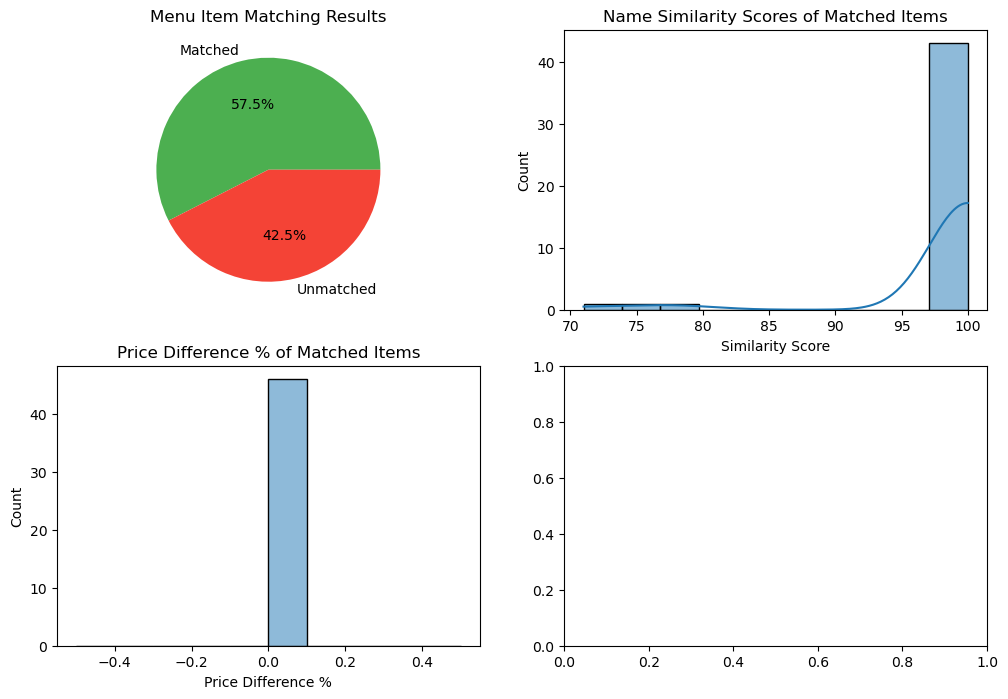

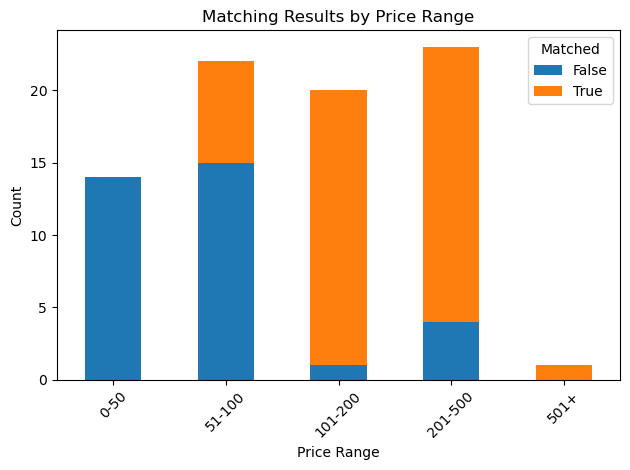

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a summary visualization
plt.figure(figsize=(12, 8))

# Plot 1: Accuracy summary
plt.subplot(2, 2, 1)
matched_count = matches_df['Matched'].sum()
unmatched_count = len(matches_df) - matched_count
plt.pie([matched_count, unmatched_count], 
        labels=['Matched', 'Unmatched'], 
        autopct='%1.1f%%',
        colors=['#4CAF50', '#F44336'])
plt.title('Menu Item Matching Results')

# Plot 2: Name similarity distribution
plt.subplot(2, 2, 2)
sns.histplot(matches_df[matches_df['Matched']]['Name_Score'], bins=10, kde=True)
plt.title('Name Similarity Scores of Matched Items')
plt.xlabel('Similarity Score')
plt.ylabel('Count')

# Plot 3: Price difference distribution
plt.subplot(2, 2, 3)
matched_with_price = matches_df[matches_df['Matched'] & (matches_df['Price_Diff'] < 0.5)]
sns.histplot(matched_with_price['Price_Diff'] * 100, bins=10, kde=True)
plt.title('Price Difference % of Matched Items')
plt.xlabel('Price Difference %')
plt.ylabel('Count')

# Plot 4: Matches by price range
plt.subplot(2, 2, 4)
matches_df['Price_Range'] = pd.cut(matches_df['Actual_Price'], 
                                  bins=[0, 50, 100, 200, 500, 1000], 
                                  labels=['0-50', '51-100', '101-200', '201-500', '501+'])
price_range_match = matches_df.groupby('Price_Range')['Matched'].value_counts().unstack().fillna(0)
price_range_match.plot(kind='bar', stacked=True)
plt.title('Matching Results by Price Range')
plt.ylabel('Count')
plt.xlabel('Price Range')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()